<a href="https://colab.research.google.com/github/kiranupgrad/semantic_processing/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [116]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning:

[W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu



In [3]:
#  TextBlob library requires specific data resources (the punkt tokenizer) from the NLTK library
nltk.download('punkt')
#  Download all necessary data for TextBlob
!python -m textblob.download_corpora

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Opening JSON file
f = open('/content/gdrive/MyDrive/Colab Notebooks/Ticket_Classficiation/complaints-2021-05-14_08_16.json','r')# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)


## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.

df.info()
#df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
#print the column names
df.columns


Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
#Assign new column names
import re

print(df.columns)

def strip_column(inputvalue):
    """Strip alpha characters"""
    inputvalue = re.sub(r'(^_)','',str(inputvalue))
    inputvalue = re.sub(r'(^source.)','',str(inputvalue))
    return inputvalue


new_columns1 =  list(map(lambda x:strip_column(x),df.columns))
print(new_columns1)

df.columns = new_columns1
df.head(5)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')
['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened']=df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)




In [10]:
#Remove all rows where complaints column is nan
df2 = df[df['complaint_what_happened'].isna() == False]

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  object 


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
pun = list(set(string.punctuation))
print(pun)

[':', '"', '#', "'", '`', '%', '=', ']', '{', '@', '.', '_', '|', '-', '}', ')', '\\', '(', '?', '>', '^', '~', '&', '*', '/', '!', ',', '<', '+', ';', '[', '$']


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  # Make the text lowercase
  text = text.lower()
  # Remove text in square brackets
  text = re.sub(r'', '', text)
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove words containing numbers
  text = re.sub(r'\b\w*\d\w*\b', '', text)
  # Remove extra whitespace
  text = ' '.join(text.split())
  return text


In [14]:
df2.complaint_what_happened=df2.complaint_what_happened.map(clean_text)

<ipython-input-14-977d718281da>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
#Write your function to Lemmatize the texts
df2['complaint_what_happened']

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told b...
10,chase card was reported on however fraudulent ...
11,on while trying to book a xxxx xxxx ticket i c...
14,my grand son give me check for i deposit it in...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had cha...


In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints

def lemmatize_text(text):
  lemma_list = []
  document = nlp(text)
  for word in document:
    # Extract lemmas and add it to list
    lemma_list.append(word.lemma_)
  return ' '.join(lemma_list)


In [17]:

df2['lemmatized_complaints']=df2.complaint_what_happened.map(lemmatize_text)

<ipython-input-17-3c9ec0a0c128>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [158]:
df_clean = df2[['complaint_what_happened', 'lemmatized_complaints']]

In [159]:

df_clean.head(10)

,complaint_what_happened,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...
15,can you please remove inquiry,can you please remove inquiry
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...
20,during the summer months i experience a declin...,during the summer month I experience a decline...
21,on xxxx i made a payment to an online retailer...,on xxxx I make a payment to an online retailer...
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...


In [160]:
#Write your function to extract the POS tags

def pos_tag(text):
  # Create a TextBlob object
  blob = TextBlob(text)
  # Extract POS tags
  pos_tags = blob.tags
  # Keep only words with the 'NN' tag (singular nouns)
  nouns = [word for word, tag in pos_tags if tag == "NN"]
  # Join the list of nouns into a single string
  cleaned_text = ' '.join(nouns)
  return cleaned_text



#df_clean["complaint_POS_removed"] =  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [161]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean["complaint_POS_removed"]=df_clean.lemmatized_complaints.map(pos_tag)
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yrs I ve have ...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




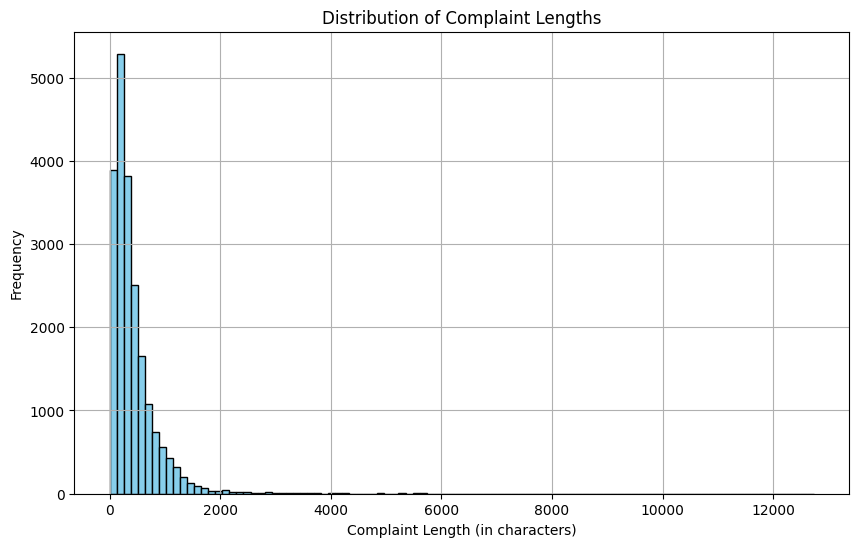

In [23]:
# Write your code here to visualise the data according to the 'Complaint' character length
# Visualize the distribution of complaint lengths
plt.figure(figsize=(10, 6))
plt.hist(df_clean["complaint_POS_removed"].apply(len), bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Complaint Lengths')
plt.xlabel('Complaint Length (in characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



#### Find the top 40 words by frequency among all the articles after processing the text.

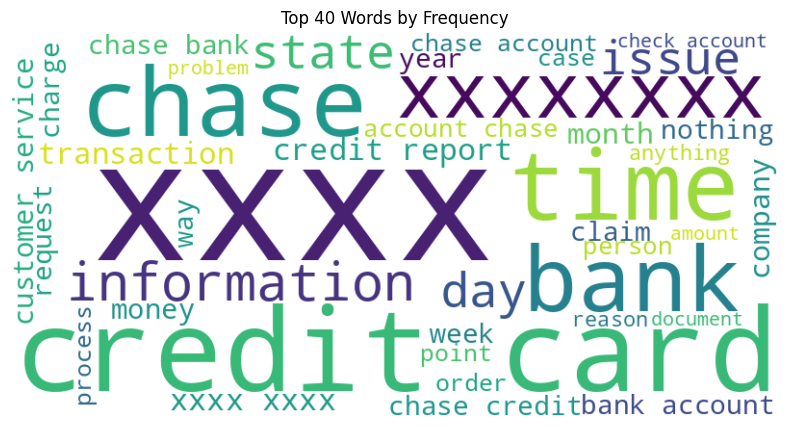

In [26]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text


# Combine all articles into a single string
text = ' '.join(df_clean["complaint_POS_removed"].tolist())

# Create and configure the WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(text)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words by Frequency')
plt.show()


In [164]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [28]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).


def plot_top_unigrams(df_clean):
  # Ensure the 'Complaint_clean' column is present
  if 'Complaint_clean' not in df_clean.columns:
    raise ValueError("The DataFrame must contain a 'Complaint_clean' column")

  # Initialize the CountVectorizer
  vectorizer = CountVectorizer()

  # Fit and transform the text data to a document-term matrix
  X = vectorizer.fit_transform(df_clean['Complaint_clean'])

  # Sum up the occurrences of each word
  word_freq = X.sum(axis=0).A1
  words = vectorizer.get_feature_names_out()

  # Create a DataFrame with words and their frequencies
  freq_df = pd.DataFrame({'Word': words, 'Frequency': word_freq})

  # Get the top 30 unigrams
  top_30 = freq_df.nlargest(30, 'Frequency')

  # Plotting
  plt.figure(figsize=(12, 8))
  sns.barplot(x='Frequency', y='Word', data=top_30, palette='viridis')
  plt.title('Top 30 Unigrams by Frequency')
  plt.xlabel('Frequency')
  plt.ylabel('Word')
  plt.show()

  return freq_df


<ipython-input-28-0c79c11b2d38>:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




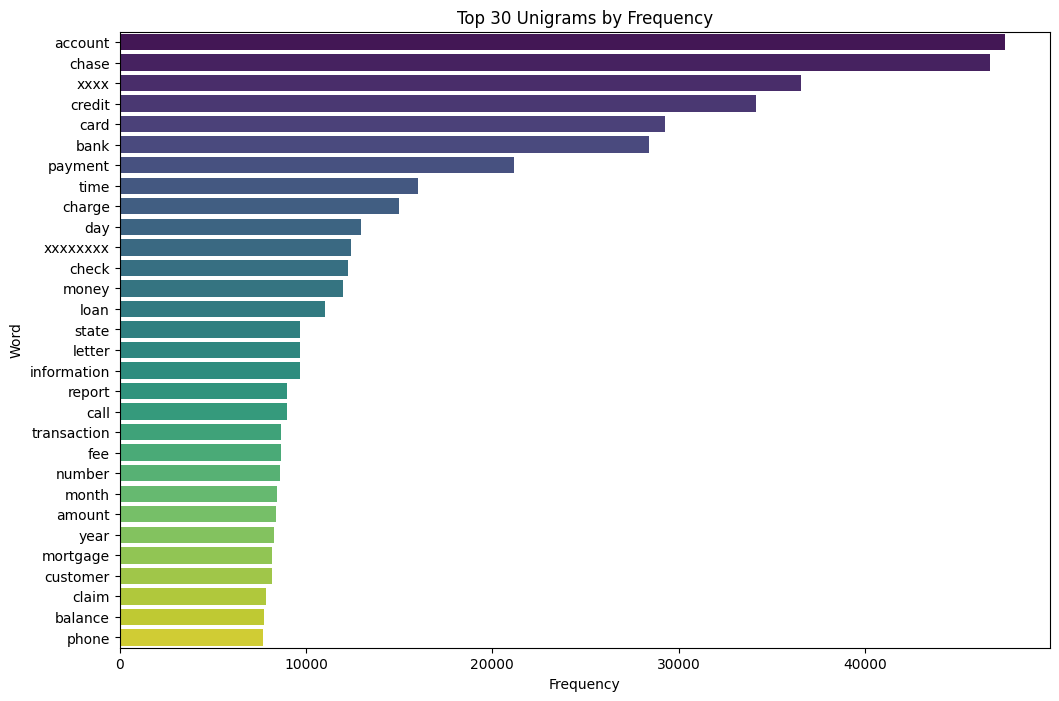

In [29]:
#Print the top 10 words in the unigram frequency
freq_df = plot_top_unigrams(df_clean)

In [30]:
top_10 = freq_df.nlargest(10, 'Frequency')
print("Top 10 Words by Frequency:", end='\n\n')
print(top_10)

Top 10 Words by Frequency:

          Word  Frequency
99     account      47535
2468     chase      46701
16412     xxxx      36580
3672    credit      34152
2118      card      29289
1261      bank      28413
10716  payment      21171
14997     time      16011
2431    charge      14995
3962       day      12976


In [32]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).

def plot_top_bigrams(df_clean):
  # Ensure the 'Complaint_clean' column is present
  if 'Complaint_clean' not in df_clean.columns:
    raise ValueError("The DataFrame must contain a 'Complaint_clean' column")

  # Initialize the CountVectorizer for bigrams
  vectorizer = CountVectorizer(ngram_range=(2, 2))

  # Fit and transform the text data to a document-term matrix
  X = vectorizer.fit_transform(df_clean['Complaint_clean'])

  # Sum up the occurrences of each bigram
  bigram_freq = X.sum(axis=0).A1
  bigrams = vectorizer.get_feature_names_out()

  # Create a DataFrame with bigrams and their frequencies
  freq_df = pd.DataFrame({'Bigram': bigrams, 'Frequency': bigram_freq})

  # Get the top 30 bigrams
  top_30 = freq_df.nlargest(30, 'Frequency')

  # Plotting
  plt.figure(figsize=(12, 8))
  sns.barplot(x='Frequency', y='Bigram', data=top_30, palette='viridis')
  plt.title('Top 30 Bigrams by Frequency')
  plt.xlabel('Frequency')
  plt.ylabel('Bigram')
  plt.show()

  return freq_df


<ipython-input-32-c5601df00c27>:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




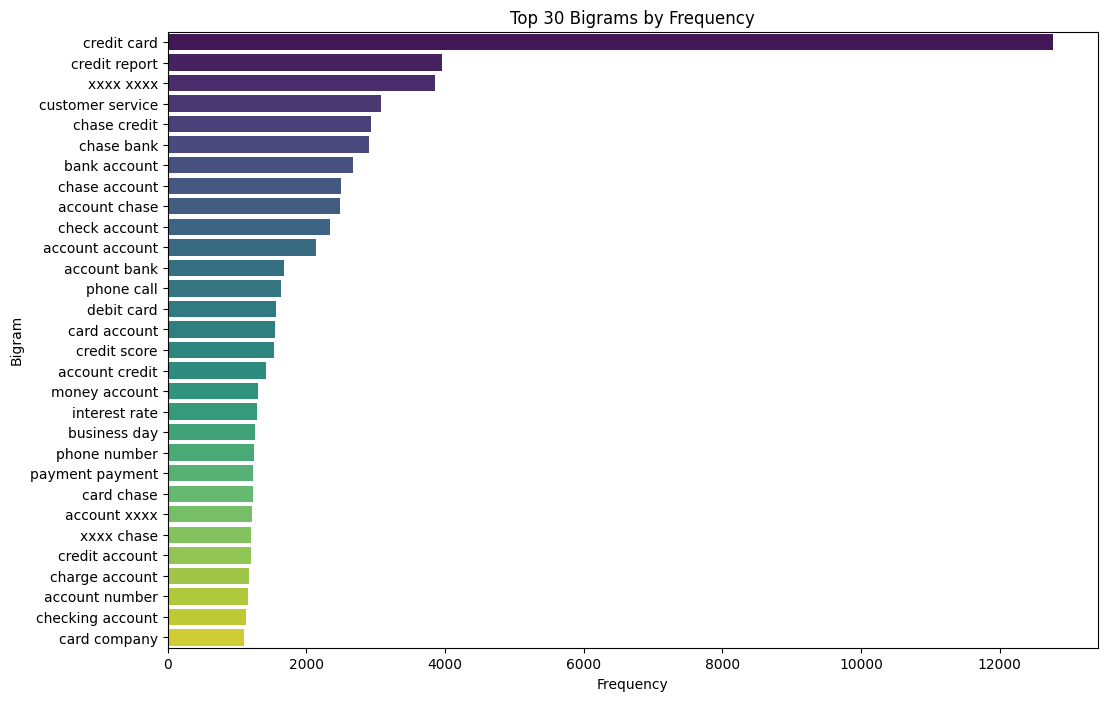

In [33]:
freq_df = plot_top_bigrams(df_clean)

In [34]:
#Print the top 10 words in the bigram frequency


top_10 = freq_df.nlargest(10, 'Frequency')
print("Top 10 Bigrams by Frequency:", end='\n\n')
print(top_10)

Top 10 Bigrams by Frequency:

                  Bigram  Frequency
80524        credit card      12774
81314      credit report       3953
325383         xxxx xxxx       3852
83892   customer service       3081
55382       chase credit       2926
54995         chase bank       2911
29020       bank account       2674
54789      chase account       2494
2052       account chase       2492
57804      check account       2335


In [35]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
def plot_top_trigrams(df_clean):
  # Ensure the 'Complaint_clean' column is present
  if 'Complaint_clean' not in df_clean.columns:
    raise ValueError("The DataFrame must contain a 'Complaint_clean' column")

  # Initialize the CountVectorizer for trigrams
  vectorizer = CountVectorizer(ngram_range=(3, 3))

  # Fit and transform the text data to a document-term matrix
  X = vectorizer.fit_transform(df_clean['Complaint_clean'])

  # Sum up the occurrences of each trigram
  trigram_freq = X.sum(axis=0).A1
  trigrams = vectorizer.get_feature_names_out()

  # Create a DataFrame with trigrams and their frequencies
  freq_df = pd.DataFrame({'Trigram': trigrams, 'Frequency': trigram_freq})

  # Get the top 30 trigrams
  top_30 = freq_df.nlargest(30, 'Frequency')

  # Plotting
  plt.figure(figsize=(12, 8))
  sns.barplot(x='Frequency', y='Trigram', data=top_30, palette='viridis')
  plt.title('Top 30 Trigrams by Frequency')
  plt.xlabel('Frequency')
  plt.ylabel('Trigram')
  plt.show()

  return freq_df



<ipython-input-35-aa0edc6876dc>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




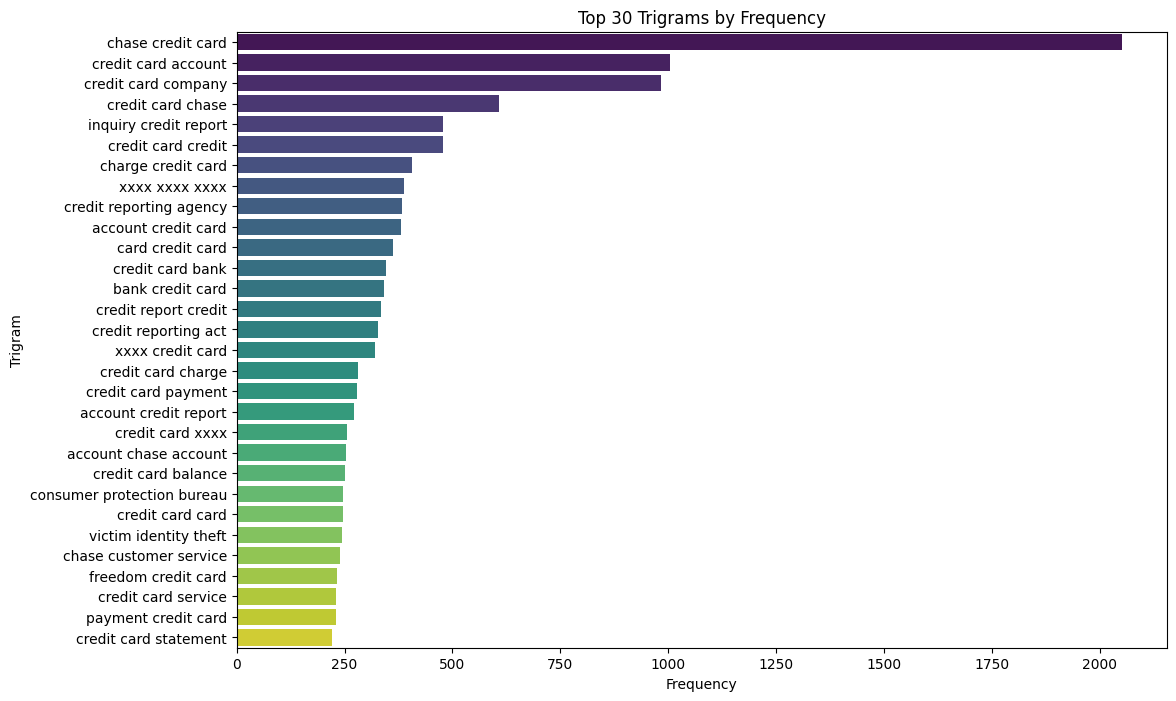

In [36]:

freq_df = plot_top_trigrams(df_clean)

In [37]:
#Print the top 10 words in the trigram frequency


top_10 = freq_df.nlargest(10, 'Frequency')
print("Top 10 Trigrams by Frequency:", end='\n\n')
print(top_10)

Top 10 Trigrams by Frequency:

                        Trigram  Frequency
182168        chase credit card       2052
257907      credit card account       1004
258119      credit card company        984
258083        credit card chase        608
437179    inquiry credit report        479
258180       credit card credit        477
169237       charge credit card        407
883784           xxxx xxxx xxxx        387
264546  credit reporting agency        384
9980        account credit card        381


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [165]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')


In [168]:
#All masked texts has been removed
df_clean.head(20)

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...
20,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month income employment month payment e...,summer month income employment month payment e...
21,on xxxx i made a payment to an online retailer...,on xxxx I make a payment to an online retailer...,xxxx payment online retailer use pay xxxx chas...,payment online retailer use pay chase websit...
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [169]:
#Write your code here to initialise the TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [170]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
document_term_matrix = vectorizer.fit_transform(df_clean.Complaint_clean)



## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [171]:
from sklearn.decomposition import NMF





## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [172]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [173]:
nmf_model.fit(document_term_matrix)
len(vectorizer.get_feature_names_out())

7263

In [174]:
#Print the Top15 words for each of the topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
  top_words_idx = topic.argsort()[-15:][::-1]  # Get indices of top 15 words
  top_words = [feature_names[i] for i in top_words_idx]  # Map indices to feature names
  print(f"Top 15 words from Topic-{topic_idx + 1}:")
  print(", ".join(top_words))
  print()

Top 15 words from Topic-1:
account, bank, check, money, fund, chase, deposit, branch, day, number, business, transaction, claim, transfer, customer

Top 15 words from Topic-2:
credit, card, report, inquiry, chase, account, score, company, limit, information, debt, application, letter, balance, year

Top 15 words from Topic-3:
payment, balance, month, fee, statement, day, time, auto, date, pay, credit, account, chase, year, mortgage

Top 15 words from Topic-4:
charge, card, fee, transaction, dispute, chase, merchant, fraud, claim, purchase, service, time, statement, refund, company

Top 15 words from Topic-5:
loan, mortgage, home, modification, chase, property, year, letter, rate, time, document, bank, house, foreclosure, sale



In [175]:
topic_distribution = nmf_model.transform(document_term_matrix)

In [176]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
best_topic = topic_distribution.argmax(axis=1)


In [186]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = best_topic #write your code to assign topics to each rows.

In [181]:
df_clean.head(20)

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
20,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month income employment month payment e...,summer month income employment month payment e...,2
21,on xxxx i made a payment to an online retailer...,on xxxx I make a payment to an online retailer...,xxxx payment online retailer use pay xxxx chas...,payment online retailer use pay chase websit...,3
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


In [187]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [189]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0:"Bank Account Services", 1:"Credit card / Prepaid card", 2:"Others",3:"Theft/Dispute reporting", 4:"Mortgages/loans" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [190]:
df_clean.head()


,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank Account Services
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card / Prepaid card
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card / Prepaid card
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account Services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [191]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

training_data = df_clean[['complaint_what_happened', 'Topic']]

In [192]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   Topic                    21072 non-null  object
dtypes: object(2)
memory usage: 493.9+ KB


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [193]:

#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

In [194]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [195]:
# Create the train & test data using the train_test_split on the tf-idf & topics
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

**MODEL - LOGISTIC REGRESSION**

In [196]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)
logreg.score(X_test, y_test)




0.9147684130599848

In [197]:
# Make predictions on test data
y_pred = logreg.predict(X_test)

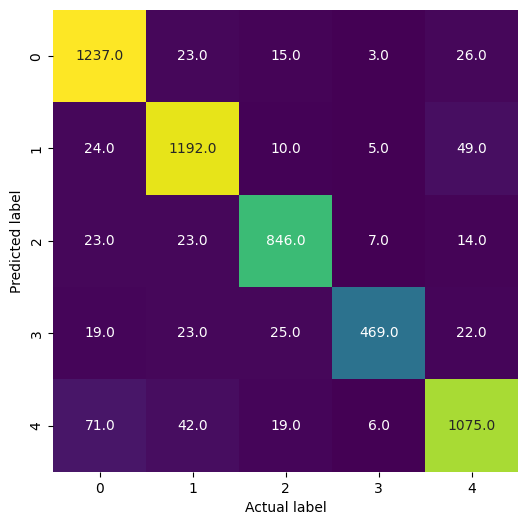

In [198]:

# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False, cmap="viridis", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [199]:

Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.90      0.95      0.92      1304
Credit card / Prepaid card       0.91      0.93      0.92      1280
                    Others       0.92      0.93      0.93       913
   Theft/Dispute reporting       0.96      0.84      0.90       558
           Mortgages/loans       0.91      0.89      0.90      1213

                  accuracy                           0.91      5268
                 macro avg       0.92      0.91      0.91      5268
              weighted avg       0.92      0.91      0.91      5268



**Interpretation - Logistic Regression**

The 91% accuracy rate is fairly good, with a precision and recall of roughly 92% for the Logistic Regression model. Separability across classes appears to be suitably explained by the model.

***MODEL - DECISION TREE***

In [200]:
from sklearn.tree import DecisionTreeClassifier

# fitting decision tree with all default hyperparams
decision_tree_classifier = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
decision_tree_classifier.score(X_test, y_test)

0.7771450265755505

In [201]:
dt_grid = {"max_depth": [5, 10, 15],
           "min_samples_split": np.arange(2, 10, 2),
           "min_samples_leaf": np.arange(9, 15, 2)}

# Hyperparameter tuning for Decision Tree
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=3,
                                verbose=True,
                                n_jobs=-1)

dt_hpt.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': array([ 9, 11, 13]),
                         'min_samples_split': array([2, 4, 6, 8])},
             verbose=True)

In [202]:

dt_hpt.best_params_

{'max_depth': 15, 'min_samples_leaf': 9, 'min_samples_split': 2}

In [203]:
decision_tree_classifier_final = DecisionTreeClassifier(random_state=42, **dt_hpt.best_params_).fit(X_train, y_train)

In [204]:
decision_tree_classifier_final.score(X_test, y_test)

0.7921412300683371

In [205]:
# Make predictions on test data
y_pred = decision_tree_classifier_final.predict(X_test)

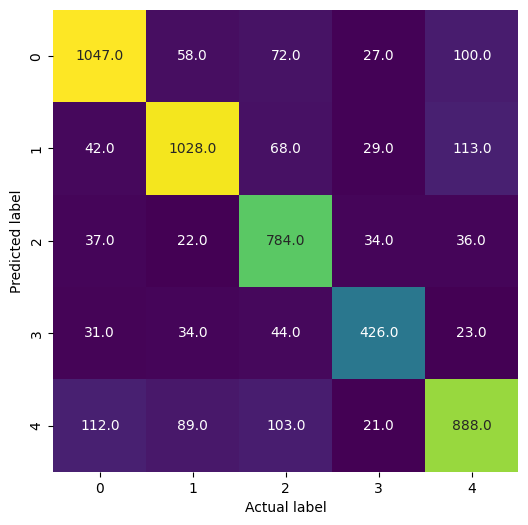

In [206]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False, cmap="viridis", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [207]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.83      0.80      0.81      1304
Credit card / Prepaid card       0.84      0.80      0.82      1280
                    Others       0.73      0.86      0.79       913
   Theft/Dispute reporting       0.79      0.76      0.78       558
           Mortgages/loans       0.77      0.73      0.75      1213

                  accuracy                           0.79      5268
                 macro avg       0.79      0.79      0.79      5268
              weighted avg       0.79      0.79      0.79      5268



**Interpretation - Decision Tree**

A close to 80% accuracy, recall, and precision is achieved based on the selected hyperparameter setting. While it performs better than a random guesser, it falls short of the aforementioned logistic regression model, whose test performance metrics approach 92%


***MODEL - RANDOM FOREST***

In [208]:


from sklearn.ensemble import RandomForestClassifier

# fitting random forest with all default hyperparams
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
rf.score(X_test, y_test)

0.8113135914958238

In [209]:
randomforest_grid = {"n_estimators": [700, 900],
                     "min_samples_split": np.arange(5, 10, 2),
                     "min_samples_leaf": np.arange(5, 10, 2)
                     }

# hyperparameter tuning for Random Forest
random_forest_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                 param_distributions=randomforest_grid,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=-1)


random_forest_hpt.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'min_samples_leaf': array([5, 7, 9]),
                                        'min_samples_split': array([5, 7, 9]),
                                        'n_estimators': [700, 900]},
                   verbose=1)

In [210]:
random_forest_hpt.best_params_

{'n_estimators': 900, 'min_samples_split': 9, 'min_samples_leaf': 5}

In [211]:

random_forest_classifier_final = RandomForestClassifier(random_state=42, **random_forest_hpt.best_params_).fit(X_train, y_train)
random_forest_classifier_final.score(X_test, y_test)

0.8052391799544419

In [212]:
# Make predictions on test data
y_pred = random_forest_classifier_final.predict(X_test)

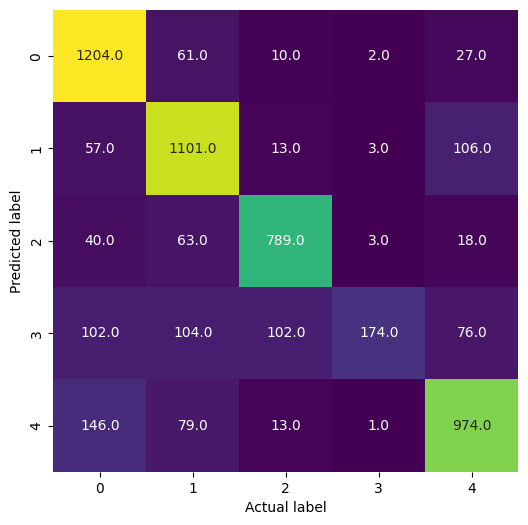

In [213]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False, cmap="viridis", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [214]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.78      0.92      0.84      1304
Credit card / Prepaid card       0.78      0.86      0.82      1280
                    Others       0.85      0.86      0.86       913
   Theft/Dispute reporting       0.95      0.31      0.47       558
           Mortgages/loans       0.81      0.80      0.81      1213

                  accuracy                           0.81      5268
                 macro avg       0.83      0.75      0.76      5268
              weighted avg       0.82      0.81      0.79      5268




**Interpretation - Random Forest**

The RandomForest model performs somewhat less well than the logistic regression model based on the hyperparameter that was chosen. Although recall is higher for decision tree, its precision and recall weighted average came out to be 84% and 75%, respectively, higher than decision trees' precision, which resulted in slightly lower weighted f1 score of 76% than that of decision tree.

***Conclusion***


Compared to Decision Tree and Random Forest, the Logistic Regression algorithm produced a better model with wider precision and a recall average of almost 91%, yielding an approximate F1 score of 91%. Therefore, out of the two models, the logistic regression model is the better option.